In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('./data/202309-baywheels-tripdata.csv')

# Initial data preparation

In [3]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,AA87D1D2A84A7A97,electric_bike,2023-09-26 09:09:42,2023-09-26 09:13:25,3rd St at Townsend St,SF-J29-1,2nd St at Folsom St,SF-H29,37.778929,-122.392475,37.785199,-122.396217,member
1,ADEA8EFEF698A13A,classic_bike,2023-09-06 16:11:32,2023-09-06 18:44:16,MLK Jr Way at University Ave,BK-C6,MLK Jr Way at University Ave,BK-C6,37.871719,-122.273068,37.871719,-122.273068,casual
2,4ABF4F02A3641351,electric_bike,2023-09-17 14:20:29,2023-09-17 14:20:44,Stowe Lake,L1.4,Stowe Lake,L1.4,37.770890,-122.477073,37.770938,-122.477116,casual
3,B33494F72AD5877A,electric_bike,2023-09-27 07:16:43,2023-09-27 07:33:24,Stowe Lake,L1.4,Stowe Lake,L1.4,37.770945,-122.477155,37.770938,-122.477116,member
4,84D3A6DAE3BD13CB,electric_bike,2023-09-12 17:13:50,2023-09-12 17:42:55,3rd St at Townsend St,SF-J29-1,NaN,NaN,37.778615,-122.392783,37.790000,-122.480000,member


In [4]:
df['started_at'] = pd.to_datetime(df['started_at']).dt.floor('H')
df['ended_at'] = pd.to_datetime(df['ended_at'])

In [5]:
df.dtypes

ride_id                       object
rideable_type                 object
started_at            datetime64[ns]
ended_at              datetime64[ns]
start_station_name            object
start_station_id              object
end_station_name              object
end_station_id                object
start_lat                    float64
start_lng                    float64
end_lat                      float64
end_lng                      float64
member_casual                 object
dtype: object

In [6]:
df.columns = df.columns.str.lower().str.replace(' ', '_')

string_columns = list(df.dtypes[df.dtypes == 'object'].index)

for col in string_columns:
    df[col] = df[col].str.lower().str.replace(' ', '_')

In [7]:
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
0,aa87d1d2a84a7a97,electric_bike,2023-09-26 09:00:00,2023-09-26 09:13:25,3rd_st_at_townsend_st,sf-j29-1,2nd_st_at_folsom_st,sf-h29,37.778929,-122.392475,37.785199,-122.396217,member
1,adea8efef698a13a,classic_bike,2023-09-06 16:00:00,2023-09-06 18:44:16,mlk_jr_way_at_university_ave,bk-c6,mlk_jr_way_at_university_ave,bk-c6,37.871719,-122.273068,37.871719,-122.273068,casual
2,4abf4f02a3641351,electric_bike,2023-09-17 14:00:00,2023-09-17 14:20:44,stowe_lake,l1.4,stowe_lake,l1.4,37.770890,-122.477073,37.770938,-122.477116,casual
3,b33494f72ad5877a,electric_bike,2023-09-27 07:00:00,2023-09-27 07:33:24,stowe_lake,l1.4,stowe_lake,l1.4,37.770945,-122.477155,37.770938,-122.477116,member
4,84d3a6dae3bd13cb,electric_bike,2023-09-12 17:00:00,2023-09-12 17:42:55,3rd_st_at_townsend_st,sf-j29-1,NaN,NaN,37.778615,-122.392783,37.790000,-122.480000,member


In [8]:
# df.isnull().sum()

In [9]:
df.member_casual.value_counts()

member    167454
casual     83726
Name: member_casual, dtype: int64

In [10]:
df.member_casual = (df.member_casual == 'member').astype(int)

In [11]:
# df['ride_duration'] = (df['ended_at'] - df['started_at']).dt.total_seconds() / 60

In [12]:
df.isnull().sum()

ride_id                   0
rideable_type             0
started_at                0
ended_at                  0
start_station_name    37854
start_station_id      37854
end_station_name      43979
end_station_id        43979
start_lat                 0
start_lng                 0
end_lat                 136
end_lng                 136
member_casual             0
dtype: int64

In [13]:
df.dropna(subset=['start_station_id', 'end_station_id'], inplace=True)
df = df.drop(columns=['start_lat', 'start_lng', 'end_lat', 'end_lng', 'start_station_id', 'end_station_id'])

In [14]:
df['start_hour_of_day'] = df['started_at'].dt.hour
df['start_weekday'] = df['started_at'].dt.weekday

In [15]:
#df.isnull().sum()
df.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_hour_of_day,start_weekday
0,aa87d1d2a84a7a97,electric_bike,2023-09-26 09:00:00,2023-09-26 09:13:25,3rd_st_at_townsend_st,2nd_st_at_folsom_st,1,9,1
1,adea8efef698a13a,classic_bike,2023-09-06 16:00:00,2023-09-06 18:44:16,mlk_jr_way_at_university_ave,mlk_jr_way_at_university_ave,0,16,2
2,4abf4f02a3641351,electric_bike,2023-09-17 14:00:00,2023-09-17 14:20:44,stowe_lake,stowe_lake,0,14,6
3,b33494f72ad5877a,electric_bike,2023-09-27 07:00:00,2023-09-27 07:33:24,stowe_lake,stowe_lake,1,7,2
5,8d3c55e6d82c11bf,electric_bike,2023-09-23 17:00:00,2023-09-23 17:12:31,brannan_st_at_7th_st,23rd_st_at_tennessee_st,1,17,5


In [16]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)

In [17]:
df_train, df_val = train_test_split(df_train_full, test_size=0.33, random_state=11)

In [18]:
y_train = df_train.member_casual.values
y_val = df_val.member_casual.values

In [19]:
del df_train['member_casual']
del df_val['member_casual']


# Exploratory data analysis

In [20]:
df_train_full.head()

,ride_id,rideable_type,started_at,ended_at,start_station_name,end_station_name,member_casual,start_hour_of_day,start_weekday
84866,6e1d91e0c627f9bb,electric_bike,2023-09-12 19:00:00,2023-09-12 20:05:03,29th_st_at_tiffany_ave,church_st_at_duboce_ave,1,19,1
230296,bdf4e86cd63c5b42,classic_bike,2023-09-22 09:00:00,2023-09-22 09:50:48,telegraph_ave_at_alcatraz_ave,bancroft_way_at_college_ave,1,9,4
146453,9dfb13e83f13c5c8,classic_bike,2023-09-27 08:00:00,2023-09-27 08:16:45,mechanics_monument_plaza_(market_st_at_bush_st),davis_st_at_jackson_st,1,8,2
171435,91f509633a2ecd92,electric_bike,2023-09-01 17:00:00,2023-09-01 17:27:33,market_st_at_steuart_st,civic_center/un_plaza_bart_station_(market_st_...,0,17,4
119076,fe3c2957f5b56c60,electric_bike,2023-09-25 08:00:00,2023-09-25 09:06:39,pier_1/2_at_the_embarcadero,illinois_st_at_20th_st,1,8,0


In [21]:
df_train_full.isnull().sum()

ride_id               0
rideable_type         0
started_at            0
ended_at              0
start_station_name    0
end_station_name      0
member_casual         0
start_hour_of_day     0
start_weekday         0
dtype: int64

In [22]:
# df.dropna(subset=['start_station_id', 'end_station_id']).shape

In [23]:
df_train_full.member_casual.value_counts()

1    103268
0     45108
Name: member_casual, dtype: int64

In [24]:
df_train_full.rideable_type.value_counts()

electric_bike    88962
classic_bike     59414
Name: rideable_type, dtype: int64

In [25]:
# df_train_full.start_part_of_day.value_counts()

In [26]:
df_train_full.start_hour_of_day.value_counts()

17    16001
18    13380
16    12768
8     10471
15     9917
19     9056
12     8859
14     8740
9      8711
13     8499
11     7639
10     7176
7      5680
20     5346
21     4596
22     3257
6      2199
23     2132
0      1181
1       816
5       775
2       623
3       307
4       247
Name: start_hour_of_day, dtype: int64

In [27]:
categorical = ['rideable_type',
               'start_station_name']
numerical = ['start_hour_of_day', 'start_weekday']

In [28]:
# One-hot encoding

In [29]:
dv = DictVectorizer()

train_dict = df_train[categorical + numerical].to_dict(orient='records')
# X_train = dv.transform(train_dict)
dv.fit(train_dict)

DictVectorizer()

In [30]:
# dv.get_feature_names()

In [31]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

In [32]:


y_train = df_train.member_casual.values
y_val = df_val.member_casual.values
y_test = df_test.member_casual.values

# X_train=dv.transform(train_dc)
# X_val=dv.transform(dict_val)
# X_test=dv.transform(dict_test)

# Logistic Regression

In [58]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')

X_train = dv.fit_transform(train_dict)
y_train = df_train['member_casual']

model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)
model.fit(X_train, y_train)

val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)
y_val = df_val['member_casual']

y_pred = model.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
accuracy

0.7135924947430852

In [65]:
train_dict

[{'rideable_type': 'electric_bike',
  'start_station_name': '11th_st_at_natoma_st',
  'start_hour_of_day': 18,
  'start_weekday': 0},
 {'rideable_type': 'classic_bike',
  'start_station_name': 'parker_st_at_fulton_st',
  'start_hour_of_day': 8,
  'start_weekday': 3},
 {'rideable_type': 'electric_bike',
  'start_station_name': '22nd_st_caltrain_station',
  'start_hour_of_day': 13,
  'start_weekday': 6},
 {'rideable_type': 'electric_bike',
  'start_station_name': 'folsom_st_at_3rd_st',
  'start_hour_of_day': 18,
  'start_weekday': 2},
 {'rideable_type': 'electric_bike',
  'start_station_name': 'valencia_st_at_16th_st',
  'start_hour_of_day': 15,
  'start_weekday': 5},
 {'rideable_type': 'classic_bike',
  'start_station_name': 'dolores_st_at_15th_st',
  'start_hour_of_day': 16,
  'start_weekday': 3},
 {'rideable_type': 'classic_bike',
  'start_station_name': 'brannan_st_at_7th_st',
  'start_hour_of_day': 11,
  'start_weekday': 3},
 {'rideable_type': 'electric_bike',
  'start_station_name'

In [34]:
C_vals=[0.00001,0.0001,0.001,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,1,2,5,10,100]
for C in C_vals:
    model = LogisticRegression(solver='liblinear', random_state=42, C=C)
    model.fit(X_train, y_train)
    y_pred = model.predict_proba(X_val)[:, 1]
    print(f'c={C}, accuracy_score={accuracy_score(y_val, y_pred >= 0.5)}, auc={roc_auc_score(y_val, y_pred >= 0.5)}')

c=1e-05, accuracy_score=0.6954224402868389, auc=0.5020959674847714
c=0.0001, accuracy_score=0.6960694451932927, auc=0.5000112620666275
c=0.001, accuracy_score=0.6961233622688305, auc=0.5
c=0.01, accuracy_score=0.704830969968189, auc=0.5208510670227504
c=0.05, accuracy_score=0.7111931848816521, auc=0.5443915382314661
c=0.1, accuracy_score=0.7116514800237235, auc=0.5498695544850125
c=0.2, accuracy_score=0.712433277619022, auc=0.5547051278999718
c=0.3, accuracy_score=0.7135655362053163, auc=0.5579678358675342
c=0.4, accuracy_score=0.7136733703563919, auc=0.5589450864104909
c=0.5, accuracy_score=0.7137272874319297, auc=0.5595336891495905
c=0.6, accuracy_score=0.713942955734081, auc=0.5602634662571443
c=0.7, accuracy_score=0.7139968728096188, auc=0.5605771309602856
c=1, accuracy_score=0.7138890386585431, auc=0.5610995424316466
c=2, accuracy_score=0.713915997196312, auc=0.5617437649378705
c=5, accuracy_score=0.713942955734081, auc=0.5622380212426626
c=10, accuracy_score=0.7135924947430852, a

# Random Forest

In [35]:
rf = RandomForestClassifier(n_estimators=10, random_state=42)
rf.fit(X_train, y_train)
y_pred = rf.predict_proba(X_val)[:, 1]
roc_auc_score(y_val, y_pred)

0.6445282122396168

In [ ]:
aucs = []

for i in range(10, 201, 10):
    rf = RandomForestClassifier(n_estimators=i, random_state=42)
    rf.fit(X_train, y_train)
    y_pred = rf.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred)
    print('%s -> %.3f' % (i, auc))
    aucs.append(auc)

# XGBoost

In [36]:
features = list(dv.get_feature_names_out())
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

In [37]:
xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'nthread': 8,
    
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)


In [38]:
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)

0.6253618772049669

In [39]:
watchlist = [(dtrain, 'train'), (dval, 'val')]

In [40]:
%%capture output

xgb_params = {
    'eta': 0.3, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [41]:
s = output.stdout
print(s[:200])

[0]	train-auc:0.60005	val-auc:0.59304
[5]	train-auc:0.62371	val-auc:0.61337
[10]	train-auc:0.63710	val-auc:0.62719
[15]	train-auc:0.64746	val-auc:0.63474
[20]	train-auc:0.65425	val-auc:0.64073
[25]	tr


In [42]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        it_line, train_line, val_line = line.split('\t')

        it = int(it_line.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
    
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [43]:
df_score = parse_xgb_output(output)

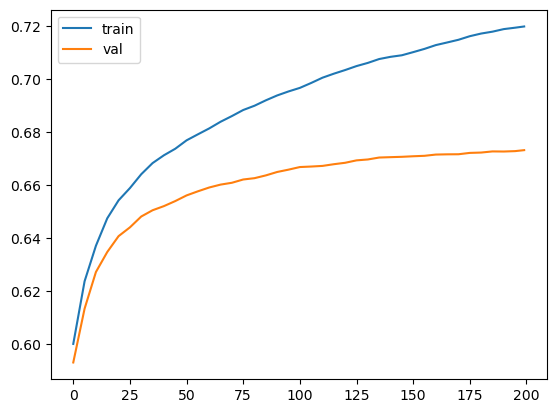

In [44]:
plt.plot(df_score.num_iter, df_score.train_auc, label='train')
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

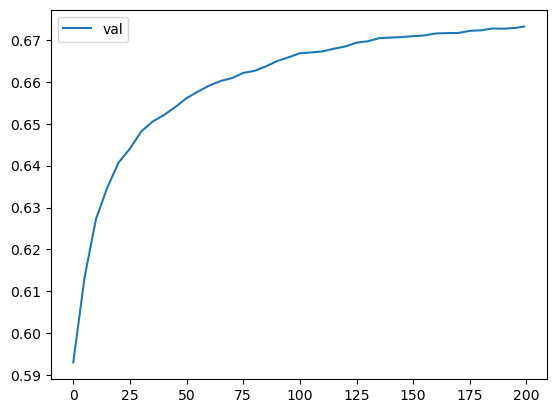

In [45]:
plt.plot(df_score.num_iter, df_score.val_auc, label='val')
plt.legend()

# XGBoost parameter tuning

In [46]:
scores = {}

In [47]:
%%capture output

xgb_params = {
    'eta': 0.01, 
    'max_depth': 6,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [48]:
key = 'eta=%s' % (xgb_params['eta'])
scores[key] = parse_xgb_output(output)
key

'eta=0.01'

In [49]:
scores = {}

In [50]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 10,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [51]:
key = 'max_depth=%s' % (xgb_params['max_depth'])
scores[key] = parse_xgb_output(output)
key


'max_depth=10'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


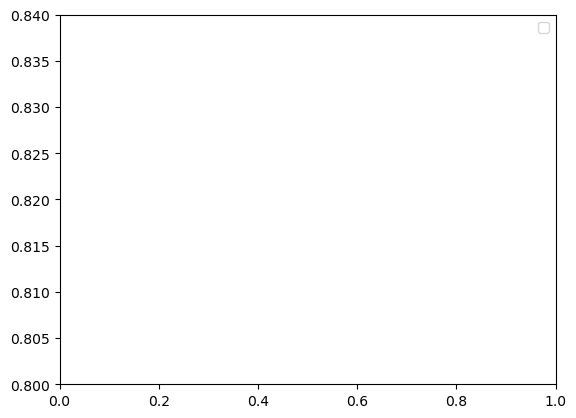

In [52]:
del scores['max_depth=10']

for max_depth, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=max_depth)

plt.ylim(0.8, 0.84)
plt.legend()

In [53]:
scores = {}

In [54]:
%%capture output

xgb_params = {
    'eta': 0.1, 
    'max_depth': 3,
    'min_child_weight': 30,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [55]:
key = 'min_child_weight=%s' % (xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)
key

'min_child_weight=30'

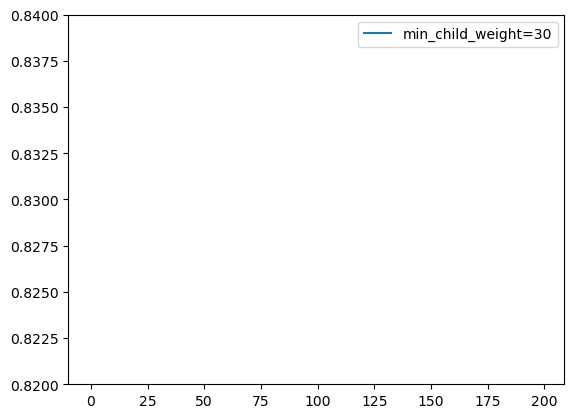

In [56]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.82, 0.84)
plt.legend()